In [1]:
# ROBERT HEETER
# ELEC 378 Machine Learning
# 13 February 2023

# PROBLEM SET 4


In [2]:
import numpy as np
import matplotlib.pyplot as plt


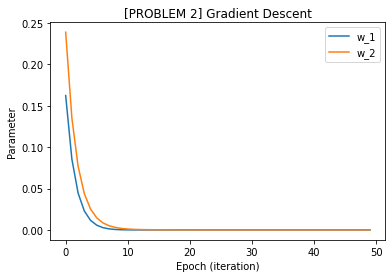

In [3]:
# PROBLEM 2

# GD (Gradient Descent)
T = 50 # number of epochs
w = np.empty((T, 2))
w[0] = np.random.rand(1,2) # start with random w 

grad_L = lambda x: np.array([[8*x[0]+x[1],x[0]+8*x[1]]])
mu = 0.05

for t in range(1,T):
    w[t] = w[t-1] - mu*grad_L(w[t-1])

fig,ax = plt.subplots(1,1)
ax.plot(w[:,0])
ax.plot(w[:,1])
ax.set_xlabel('Epoch (iteration)')
ax.set_ylabel('Parameter')
ax.legend(('w_1','w_2'))
plt.title('[PROBLEM 2] Gradient Descent')
plt.show()


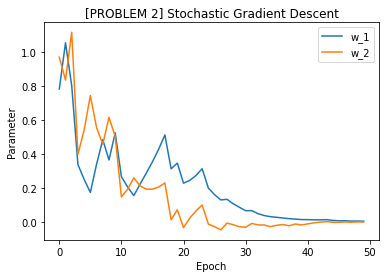

In [4]:
# SGD (Stochastic Gradient Descent)
T = 50 # number of epochs
w = np.empty((T, 2))
w[0] = np.random.rand(1,2) # start with random w

grad_L1 = lambda x: np.array([[4*x[0]+x[1], x[0]-8*x[1]]])
grad_L2 = lambda x: np.array([[6*x[0]+4*x[1], 4*x[0]+10*x[1]]])
grad_L3 = lambda x: np.array([[-2*x[0]-4*x[1], -4*x[0]+6*x[1]]])
grads = [grad_L1, grad_L2, grad_L3]

mu = 0.05

for t in range(1,T):
    i = np.random.choice(3)  # randomly select one of the gradients
    w[t] = w[t-1] - mu*grads[i](w[t-1])

fig, ax = plt.subplots(1,1)
ax.plot(w[:,0])
ax.plot(w[:,1])
ax.set_xlabel('Epoch')
ax.set_ylabel('Parameter')
ax.legend(('w_1','w_2'))
plt.title('[PROBLEM 2] Stochastic Gradient Descent')
plt.show()


(248, 208, 3)


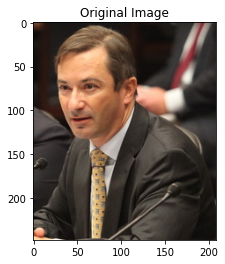

In [5]:
# PROBLEM 3

import numpy as np

import scipy.io as sc
from scipy import signal, linalg

import matplotlib.image as im
import matplotlib.pyplot as plt

import time
from sklearn.decomposition import PCA

# read in original image and show image and shape
image = im.imread('objection.png')
print(image.shape)
plt.imshow(image)
plt.title('Original Image')
plt.show()


In [6]:
# form the nxp data matrix, n = # of pixels, p = 3 (R,G,B color values)
X = image.reshape(-1,3)
print(np.shape(X))


(51584, 3)


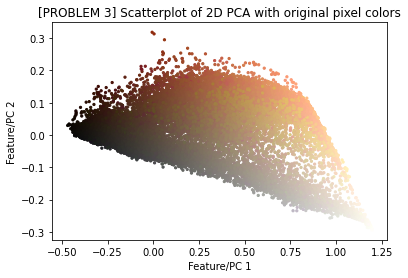

In [7]:
# run and plot PCA on flattened array
pca = PCA(n_components=2)
pca.fit(X)

# project pixels into 2D space
pixels_transformed = pca.fit_transform(X)

# plot pixels in 2D space with original colors
plt.scatter(pixels_transformed[:, 0],pixels_transformed[:,1],c=X,s=5)
plt.xlabel('Feature/PC 1')
plt.ylabel('Feature/PC 2')
plt.title('[PROBLEM 3] Scatterplot of 2D PCA with original pixel colors')
plt.show()


In [8]:
# implement k-means
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def kmeans(X, k=3, max_iterations=100):
    '''
    Parameter:
    X: multidimensional data (ndarray)
    k: number of clusters (int)
    max_iterations: number of repetitions before clusters are established (int)
    
    Steps:
    1. Convert data to numpy array if necessary
    2. Pick indices of k random points without replacement
    3. Find class (P) of each data point using Euclidean distance.
    4. Stop when max_iteration is reached or P matrix doesn't change.
    
    Return:
    P: an np.array containing class of each data point
    centroids: an np.array containing the centroid of each class 
    '''

    # choose k random data points to serve as the initial centroids
    centroid_indices = np.random.default_rng().choice(len(X),k,replace=False)
    centroids = X[centroid_indices,:]
    
    # assign a cluster label to each data point based on closest centroid
    P = distance.cdist(X,centroids,'euclidean').argmin(axis=1)

    for iteration in range(max_iterations):
        # move centroids to the average of their cluster points
        # X[?,?].mean(axis=0) calculates the mean value, along each dimension, of all elements of X belonging to the class i.
        # np.vstack then stacks these mean values of each class, returning a (k,N) array,
        # where each of the k rows is a class containing N columns (dimensions).
        # Thus, "centroids" is a (k,N) array contining the N-dimensional coordinates of each of the k centroids.
        centroids = np.vstack([X[np.where(P==i)[0],:].mean(axis=0) for i in np.unique(P)])
        
        # re-assign clusters based on new centroids
        tmp = distance.cdist(X,centroids,'euclidean').argmin(axis=1)

        if np.array_equal(P,tmp): break # exit if P stops changing
        P = tmp

    return P,centroids # return arrays of classes and their centroids

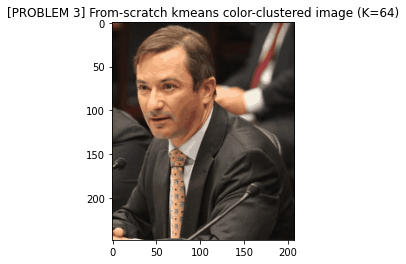

In [9]:
# run kmeans on pixels (from-scratch implementation)
K = 2**6

labels,centroids = kmeans(X,k=K,max_iterations=100)

# replace each pixel with its nearest centroid, then plot the resulting image
color_quantized_data_matrix = np.take(centroids,labels,axis=0)
plt.imshow(color_quantized_data_matrix.reshape(image.shape))
plt.title('[PROBLEM 3] From-scratch kmeans color-clustered image (K=64)')
plt.show()


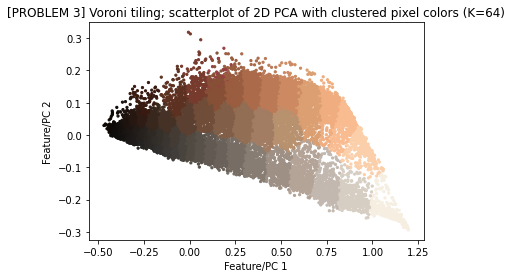

In [10]:
# show previous PCA plot with new color quantization scheme (Voronoi tiling)
# plot pixels in 2D space, with each pixel having its quantized color

plt.scatter(pixels_transformed[:, 0],pixels_transformed[:, 1],c=color_quantized_data_matrix,s=5)
plt.xlabel('Feature/PC 1')
plt.ylabel('Feature/PC 2')
plt.title('[PROBLEM 3] Voroni tiling; scatterplot of 2D PCA with clustered pixel colors (K=64)')
plt.show()


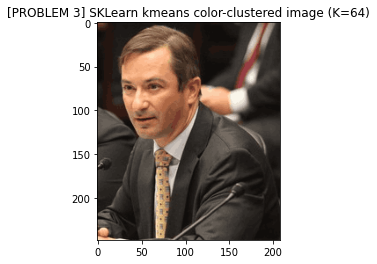

In [11]:
# run sklearn implementation for comparison
# SKLearn implementation of kmeans
from sklearn.cluster import KMeans

K = 2**6

kmeans = KMeans(n_clusters=K,random_state=0,algorithm="lloyd",n_init='auto').fit(X)

# replace each pixel with its nearest centroid, then plot the resulting image
labels = kmeans.predict(X)
kmeans_flat = kmeans.cluster_centers_[labels]

plt.figure(0)
plt.title('[PROBLEM 3] SKLearn kmeans color-clustered image (K=64)')
plt.imshow(kmeans_flat.reshape(image.shape))
plt.show()


In [12]:
# PROBLEM 4

import scipy.io as sc
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

cancer = sc.loadmat('cancer.mat')
X = np.array(cancer['X'])
Y = ([y[0][:] for y in np.concatenate(cancer['Y'][:])])


In [13]:
# use PCA to reduce the dimensionality of X
false_negative = []
false_positive = []
error = []
p_range = np.arange(2,64,1)

for p in p_range:
    pca = PCA(n_components=p)
    pca.fit(X)
    patients_transformed = pca.fit_transform(X)
    
    K = 14 # 14 clusters for 14 different cancers
    kmeans = KMeans(n_clusters=K, random_state=0, algorithm="lloyd",n_init='auto').fit(patients_transformed)
    labels = kmeans.labels_
    
    # the indices of patients who have melanoma
    i_melanoma = np.char.startswith(Y,'MELANOMA') 

    # the k-means prediction of melanoma patients
    melanoma_labels = labels[i_melanoma]
    
    # clusters for melanoma patients
    major_label, major_label_count = stats.mode(melanoma_labels,keepdims=True)

    # false negative: melanoma patients not included in cluster
    fn = np.sum(i_melanoma) - major_label_count[0]

    # false positive: non-melanoma patients included in cluster
    fp = len([y for i,y in enumerate(Y) if labels[i]==major_label[0] and y[0:8] not in ['MELANOMA']])
    
    false_negative.append(fn)
    false_positive.append(fp)

    # error: sum of false positives and false negatives
    error.append(false_negative[-1] + false_positive[-1])

print('[PROBLEM 4]')
print('number of PCs retained:\n', list(p_range), '\n')
print('number of melanoma patients not included in cluster (false negative):\n', false_negative, '\n')
print('number of non-melanoma patients included in cluster (false positive):\n', false_positive, '\n')
print('total error:\n', error, '\n')


[PROBLEM 4]
number of PCs retained:
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63] 

number of melanoma patients not included in cluster (false negative):
 [3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 3, 2, 2, 3, 2, 2, 2] 

number of non-melanoma patients included in cluster (false positive):
 [0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0] 

total error:
 [3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 4, 5, 3, 4, 4, 3, 2, 2, 2]